<a href="https://colab.research.google.com/github/aaoiii/2024-ESAA-OB/blob/main/1%EC%A3%BC%EC%B0%A8_%ED%95%B8%EC%A6%88%EC%98%A83%EC%9E%A5%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3. 분류
## 3.1 MNIST


In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y=mnist['data'],mnist['target']
X.shape
y.shape

(70000,)

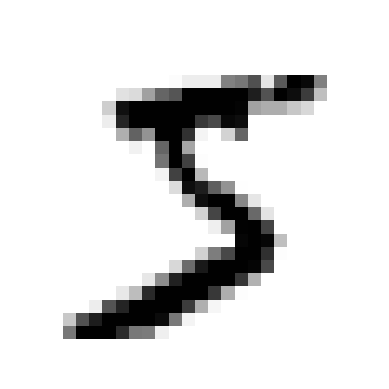

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

In [6]:
y=y.astype(np.uint8)

In [7]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## 3.2 이진 분류기 훈련

- 이진분류기 : 두 개의 클래스를 구분

In [8]:
y_train_5=(y_train==5) #5는 True, 다른 숫자는 False
y_test_5=(y_test==5)

In [9]:
# SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기 (한 번에 하나씩 훈련 샘플을 독립적으로 처리)
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정
### 3.3.1 교차 검증을 사용한 정확도 측정


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


- StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')


array([0.87365, 0.85835, 0.8689 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차행렬
- 분류기의 성능 평가
- 예측값 필요

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

- 각 테스트 폴드에서 얻은 예측 반환

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행 : 실제 클래스 / 열 : 예측한 클래스

In [21]:
y_train_perfect_predictions=y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도
- 재현율 (민감도, 진짜 양성 비율)

## 3.3.3 정밀도와 재현율

In [22]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

- F score : 정밀도와 재현율의 조화평균

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서 F1 점수가 높다
- 재현율과 정밀도는 상황에 따라 더 중요한 것이 있다
- 정밀도/재현율 트레이드 오프

## 3.3.4 정밀도/재현율 트레이드오프

- SGDClassifier
  - 결정 함수로 각 샘플의 점수를 계산하고 임곗값보다 크면 샘플을 양성 클래스에 할당, 작으면 음성 클래스에 할당
  - 임곗값이 높을수록 재현율은 낮아지고 정밀도는 높아진다

In [25]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores
threshold=0
y_some_digit_pred=(y_scores>threshold)

In [26]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [27]:
# 적절한 임곗값 구하기 => 먼저 cross_val_predict 로 훈련세트에 있는 모든 샘플의 점수를 구하기 (결정 점수 반환하도록 지정)
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [28]:
# precision_recall_curve() 함수로 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

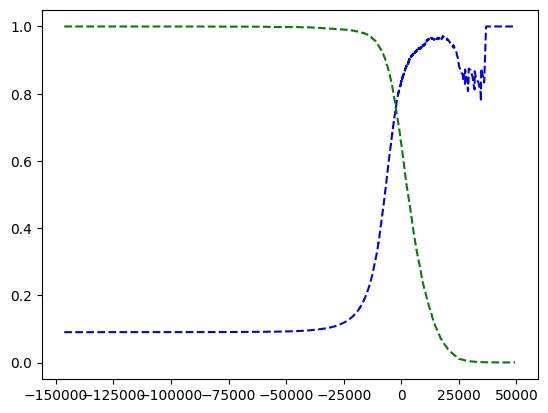

In [30]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="정밀도")
  plt.plot(thresholds,recalls[:-1],"g--",label="재현율")

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

- 정밀도가 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다

In [32]:
# 최대한 90% 정밀도가 되는 가장 낮은 임곗값
threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]

# average_precision_score() : 정밀도/재현율 곡선의 아래 면적을 계산하여 두 모델을 비교할 때 유용

In [33]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [34]:
precision_score(y_train_5,y_train_pred_90)
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선
- 거짓 양성 비율에 대한 진짜 양성 비율의 곡선
- 민감도에 대한 1-특이도 그래프

In [35]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

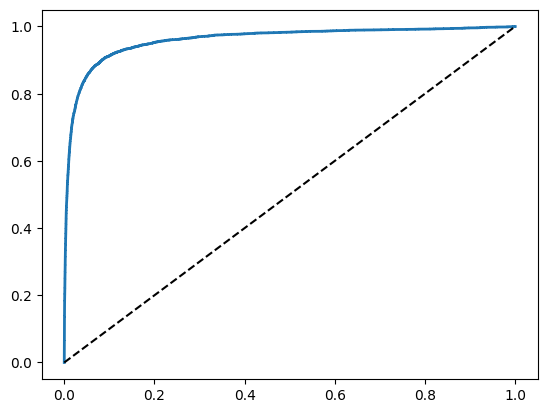

In [36]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tpr)
plt.show()

- 재현율(TPR) 과 거짓양성(FPR) 은 트레이드오프 관계
- 점선 : 완전한 랜덤 분류기의 ROC 곡선
- 좋은 분류기는 점선에서 최대한 멀리 떨어져있어야한다
- 곡선 아래 면적(AUC) : 분류기 비교
  - 완벽한 분류기=1
  - 완전한 랜덤 분류기=0.5

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

- 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요하면 PR 곡선 사용 / 아니면 ROC 곡선 사용

In [38]:
# RandomForestClassifier을 훈련시켜 SGDClassifier 의 ROC 곡선과 ROC AUC 점수 비교

#predict_proba() : 샘플이 행, 클래스가 열 / 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [40]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

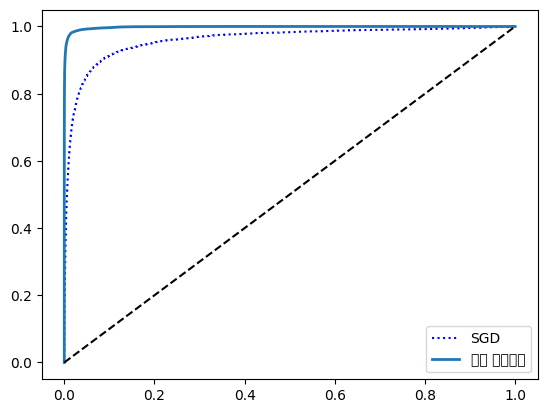

In [41]:
plt.plot(fpr,tpr,'b:',label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,'랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [42]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

## 3.4 다중 분류

다중분류기 : 둘 이상의 클래스 구별
  - 이진 분류기를 여러 개 사용해 다중 클래스 분류하는 기법도 있다
  - OvR 전략 : 10개의 숫자 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것의 클래스 선택
  - OvO 전략 : 각 숫자의 조합마다 이진 분류기를 훈련

In [43]:
#서포트 벡터 머신 분류기
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
# decision_function() : 샘플당 10개의 점수를 반환

some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

=> 가장 높은 점수가 클래스 5에 해당하는 값

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

In [48]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [49]:
# SGDClassifier 훈련
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 분류기 평가에는 교차검증 사용
  - cross_val_score()

In [51]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

cross_val_predict()으로 예측을 만들고 confusion_matrix() 함수 호출

In [53]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

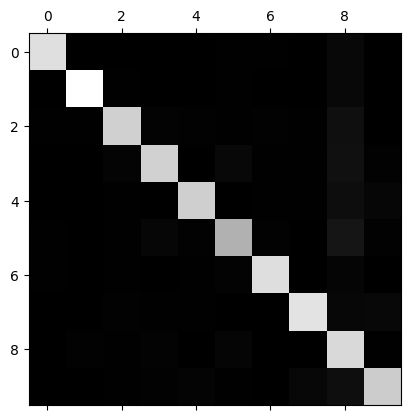

In [54]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [55]:
# 에러 비율을 비교
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

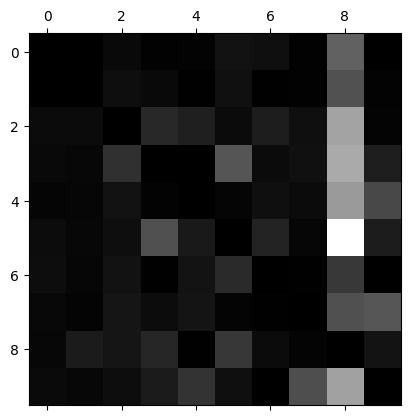

In [56]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

- 행은 실제 클래스, 열은 예측한 클래스
- 밝게 나온 클래스 8 열은 이미지가 8로 잘못 분류됨을 암시

In [58]:
cl_a,cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5)
plt.show()

선형 모델인 SGDClassifier을 사용해서 에러가 생김
- 분류기는 이미지의 위치나 회전 방향에 민감
- 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하면 에러를 줄일 수 있음

## 3.5 다중 레이블 분류
다중 레이블 분류 : 여러 개의 이진 꼬리표 출력하는 분류 시스템

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

# 두개의 타깃 레이블이 담긴 y_multilabel 배열

KNeighborsClassifier()

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [64]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605

레이블에 클래스의 지지도를 가중치로 주기
- average='weighted'

## 3.7 다중 출력 분류

다중 출력 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [65]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)